<a href="https://colab.research.google.com/github/romenlaw/ML-playground/blob/main/ml_playground4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!rm -f data/*
!wget -nv -P data https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_10_Neural_Networks/one_circle.csv
!ls -al data
!wc -l data/one_circle.csv

2025-03-04 01:44:18 URL:https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_10_Neural_Networks/one_circle.csv [4820/4820] -> "data/one_circle.csv" [1]
total 16
drwxr-xr-x 2 root root 4096 Mar  4 01:44 .
drwxr-xr-x 1 root root 4096 Mar  4 01:44 ..
-rw-r--r-- 1 root root 4820 Mar  4 01:44 one_circle.csv
111 data/one_circle.csv


In [70]:
import numpy as np
import pandas as pd
import graphviz
import matplotlib.pyplot as plt
from tensorflow import keras
import torch

# Some functions to plot our points and draw the lines
def plot_points(features, labels, point_size=25, ax=None):
  X = np.array(features)
  y = np.array(labels)
  spam = X[np.argwhere(y==1)]
  ham = X[np.argwhere(y==0)]
  if ax is None:
    p=plt
    p.xlabel('aha')
    p.ylabel('boo')
  else:
    p=ax
    p.set_xlabel('aha')
    p.set_ylabel('boo')
  p.scatter([s[0][0] for s in spam],
            [s[0][1] for s in spam],
            s = point_size,
            color = 'cyan',
            edgecolor = 'k',
            marker = '^')
  p.scatter([s[0][0] for s in ham],
            [s[0][1] for s in ham],
            s = point_size,
            color = 'red',
            edgecolor = 'k',
            marker = 's')
  p.legend(['happy','sad'])

def draw_line(a,b,c, starting=0, ending=3, **kwargs):
  # Plotting the line ax + by + c = 0
  x = np.linspace(starting, ending, 1000)
  plt.plot(x, -c/b - a*x/b, **kwargs)

f = lambda x: int(x[1]>x[0])
def g(Z):
  return np.array([f(i) for i in Z])
def plot_keras_model(X, y, model):
  X = np.array(X)
  y = np.array(y)
  plot_step = 0.2
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = g(Z).reshape(xx.shape)
  plt.contour(xx, yy, Z, colors = 'k',linewidths = 1)
  plot_points(X, y)
  plt.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.2, levels=range(-1,2))
  plt.show()

def plot_torch_model(X, y, model):
  X = np.array(X)
  y = np.array(y)
  plot_step = 0.2
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))
  Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
  Z = g(Z).reshape(xx.shape)
  plt.contour(xx, yy, Z, colors = 'k',linewidths = 1)
  plot_points(X, y)
  plt.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.2, levels=range(-1,2))
  plt.show()

# Neural Network

Neural network can be seen as compositions of linear classifiers that give rise to nonlinear classifiers.

In low dimensions, the linear classifiers would look like lines or planes, and the nonlinear classifiers would look like complicated curves or surfaces.

Boundary of a perceptron is a straight line (see ch5-6). When combined into neuro-net, the boundary of the NN becomes non-linear.

*Fully connected* architecture: every node in a layer is connected to every (non bias) node in next layer; no connections happen between non-consecutive layers.

See [Back Prop Ninja notes](https://colab.research.google.com/github/romenlaw/ML-playground/blob/main/ml_playground4.ipynb#scrollTo=-XSSCuvxW5jZ&line=11&uniqifier=1) for gradient caculations.

In [3]:
# using the alien mood example
alien_dataset = pd.DataFrame({
  'aack':[1,2,0,0,1,1,2,2],
  'beep':[0,0,1,2,1,2,1,2],
  'happy': [0,0,0,0,1,1,1,1]})

X = alien_dataset[['aack', 'beep']]
y = alien_dataset['happy']

In [4]:
X, y

(   aack  beep
 0     1     0
 1     2     0
 2     0     1
 3     0     2
 4     1     1
 5     1     2
 6     2     1
 7     2     2,
 0    0
 1    0
 2    0
 3    0
 4    1
 5    1
 6    1
 7    1
 Name: happy, dtype: int64)

These points cannot be separated with one straight line. But can be with 2 lines:
* line 1: $6x_a+10x_b-15=0$
* line 2: $10x_a+6x_b-15=0$

Looking at plot below, we can see that sentence can be classified as Happy if both line1 and line2 >=0

From linear examples in previous chapters, we saw that if a word's weight was positive, the word is likely happy... but here the weights are all positive. i.e. the problem here is not linear.

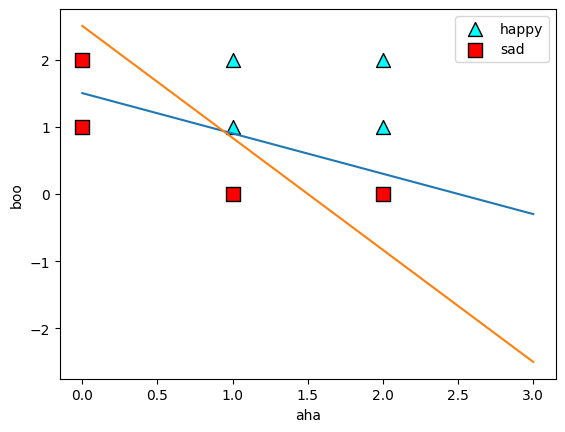

In [5]:
plot_points(X, y, point_size=100)
draw_line(6,10,-15)
draw_line(10,6,-15)

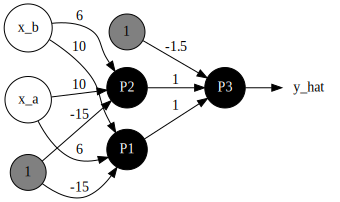

In [6]:
# the neuro-net
g = graphviz.Digraph(format='svg', graph_attr={'rankdir': 'LR'})
g.node('xa', 'x_a', shape='circle')
g.node('xb', 'x_b', shape='circle')
g.node('b1', '1', shape='circle', style='filled', fillcolor='grey')
g.node('b2', '1', shape='circle', style='filled', fillcolor='grey')
g.node('p1', 'P1', shape='circle', style='filled', fillcolor='black', fontcolor='white')
g.node('p2', 'P2', shape='circle', style='filled', fillcolor='black', fontcolor='white')
g.node('p3', 'P3', shape='circle', style='filled', fillcolor='black', fontcolor='white')
g.node('output', 'y_hat', shape='none')

g.edge('xa', 'p1', label='6')
g.edge('xa', 'p2', label='10')
g.edge('xb', 'p1', label='10')
g.edge('xb', 'p2', label='6')
g.edge('b1', 'p1', label='-15')
g.edge('b1', 'p2', label='-15')

g.edge('p1', 'p3', label='1')
g.edge('p2', 'p3', label='1')
g.edge('b2', 'p3', label='-1.5')

g.edge('p3', 'output')
g

In [7]:
def step(x):
  if x >= 0:
    return 1
  else:
    return 0

def line_1(a,b):
  return step(6*a + 10*b - 15)

def line_2(a,b):
  return step(10*a + 6*b - 15)

def bias(a,b):
  return 1

def nn_with_step(a,b):
  return step(step(6*a + 10*b - 15) + step(10*a + 6*b - 15) - 1.5)

def sigmoid(x):
  return np.exp(x)/(1.0 + np.exp(x))

def nn_with_sigmoid(a,b):
  return sigmoid(1.0*sigmoid(6*a + 10*b - 15) + 1.0*sigmoid(10*a + 6*b - 15) - 1.5)

def plot_function(f, ax=None):
  plot_points(X, y, 100, ax)

  def h(x,y): # height function of the contour
    return f(x,y)>=0.5
  xx, yy = np.meshgrid(np.arange(-0.5,3,0.005),
                       np.arange(-0.5,3,0.005))
  Z = np.array([h(i[0], i[1]) for i in np.c_[xx.ravel(), yy.ravel()]])
  Z = Z.reshape(xx.shape)
  if ax is None:
    plt.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.25, levels=range(-1,2))
    plt.contour(xx, yy, Z,colors = 'k',linewidths = 3)
  else:
    ax.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.25, levels=range(-1,2))
    ax.contour(xx, yy, Z,colors = 'k',linewidths = 3)


## Boundaries of NN 1st layer
1st layer of the neuro-net

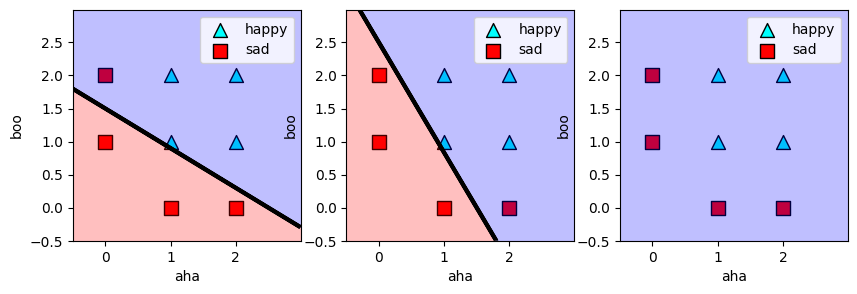

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
plot_function(line_1, ax1)
plot_function(line_2, ax2)
plot_function(bias, ax3)

## Boundaries of NN 2nd layer

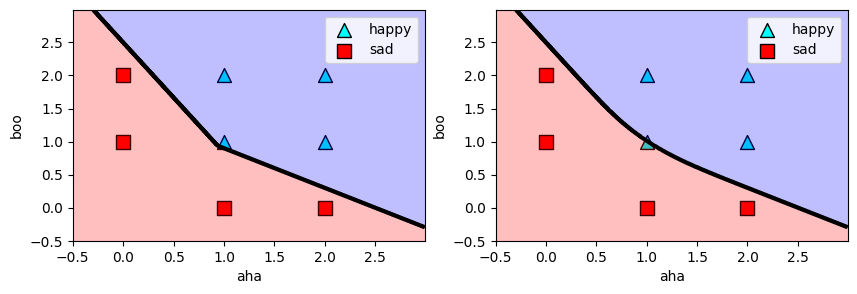

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,3))
plot_function(nn_with_step, ax1)
plot_function(nn_with_sigmoid, ax2)

# One-Circle Example

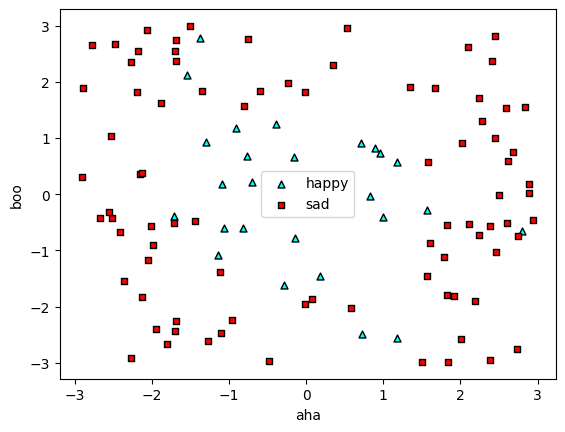

In [19]:
df = pd.read_csv('data/one_circle.csv', index_col=0)
X = np.array(df[['x_1', 'x_2']])
y = np.array(df['y']).astype(int)
plot_points(X,y)

## Tensorflow
Implement the example using Tensorflow

In [61]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical

# turn y (0 or 1) into one-hot, i.e. [0,1] and [1,0]
categorised_y = np.array(to_categorical(y, 2))

# dimensions of the nero-net
# input: (2,), hidden layer 1 (128,), hidden 2 (64,), output (2,)
# activation fn: hidden layers: ReLU, output layer: Softmax
# dropout in hidden layers, ratio 0.2
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(2,)))
model.add(Dropout(.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', # multi-value version of log loss
              optimizer='adam',
              metrics=['accuracy'])

# train the model
model.fit(X, categorised_y, epochs=100, batch_size=10)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5239 - loss: 0.6914
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7210 - loss: 0.5329 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7664 - loss: 0.4591 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8218 - loss: 0.3740 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7566 - loss: 0.4679 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7830 - loss: 0.3891 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8051 - loss: 0.3876 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7748 - loss: 0.4382 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7410 - loss: 0.4465 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8032 - loss: 0.3884 
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7725 - loss: 0.4467
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0

In [23]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 128)                 │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,312 (102.79 KB)

 Trainable params: 8,770 (34.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,542 (68.53 KB)

In [62]:
categorised_y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


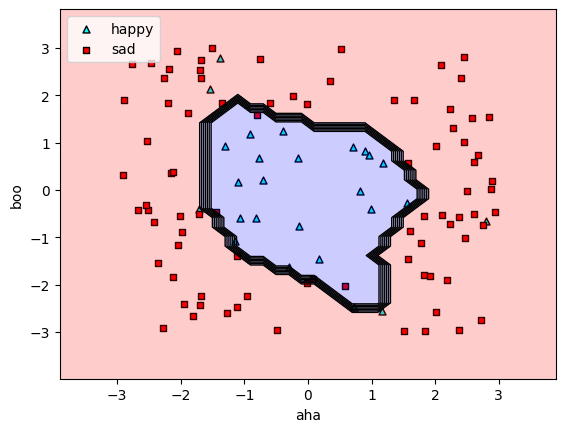

In [30]:
plot_keras_model(X, y, model)

In [42]:
model.predict(np.array([[-1,-3]])), model.predict(np.array([[0,0]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


(array([[9.9944276e-01, 5.5725832e-04]], dtype=float32),
 array([[0.02792207, 0.97207797]], dtype=float32))

## PyTorch

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class OneCircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(2, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 2)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = F.relu(self.fc3(x))
    x = F.softmax(x)
    return x

categorised_y = F.one_hot(torch.tensor(y), 2).float()

model = OneCircleModel()
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
for epoch in range(num_epochs):
  model.train()

  # generate mini-batch
  batch_size=10
  ri = np.random.permutation(X.shape[0])[:batch_size]
  Xb = torch.tensor(X[ri], dtype=torch.float32)
  yb = categorised_y[ri]
  for features, labels in zip(Xb, yb):
    outputs = model(features)
    loss = criterion(outputs, labels)

    # back prop
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
  print(f"Epoch [{epoch}/{num_epochs}], loss: {loss.item():.4f}")


<ipython-input-64-8c5982a9a03e>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Epoch [0/100], loss: 0.8050
Epoch [1/100], loss: 0.7115
Epoch [2/100], loss: 0.7127
Epoch [3/100], loss: 0.6931
Epoch [4/100], loss: 0.6935
Epoch [5/100], loss: 0.6931
Epoch [6/100], loss: 0.6931
Epoch [7/100], loss: 0.6586
Epoch [8/100], loss: 0.5375
Epoch [9/100], loss: 0.6266
Epoch [10/100], loss: 0.8390
Epoch [11/100], loss: 0.4836
Epoch [12/100], loss: 0.8956
Epoch [13/100], loss: 1.2208
Epoch [14/100], loss: 0.4732
Epoch [15/100], loss: 0.7875
Epoch [16/100], loss: 0.5782
Epoch [17/100], loss: 0.7954
Epoch [18/100], loss: 0.3233
Epoch [19/100], loss: 0.8122
Epoch [20/100], loss: 1.1888
Epoch [21/100], loss: 0.3907
Epoch [22/100], loss: 0.3652
Epoch [23/100], loss: 0.3269
Epoch [24/100], loss: 0.3360
Epoch [25/100], loss: 0.3621
Epoch [26/100], loss: 0.3543
Epoch [27/100], loss: 0.3235
Epoch [28/100], loss: 1.2924
Epoch [29/100], loss: 0.3237
Epoch [30/100], loss: 0.3376
Epoch [31/100], loss: 0.3676
Epoch [32/100], loss: 0.3134
Epoch [33/100], loss: 0.3481
Epoch [34/100], loss: 0.

<ipython-input-64-8c5982a9a03e>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


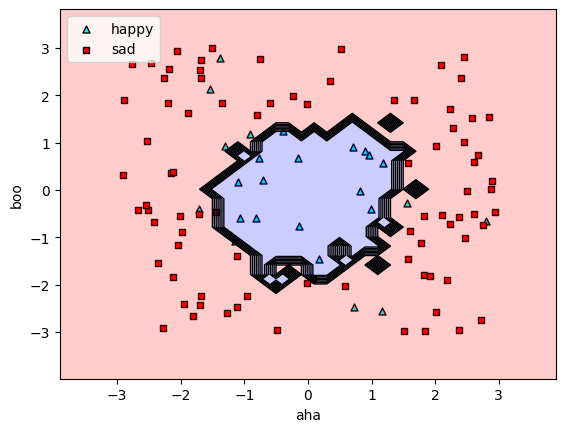

In [71]:
plot_torch_model(X, y, model)

In [67]:
model(torch.tensor([[-1.0, -3.0]])), model(torch.tensor([[0.0, 0.0]]))

<ipython-input-64-8c5982a9a03e>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


(tensor([[9.9946e-01, 5.4015e-04]], grad_fn=<SoftmaxBackward0>),
 tensor([[0.1240, 0.8760]], grad_fn=<SoftmaxBackward0>))